## 1. Load the required libraries and read the dataset.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import re

import warnings
warnings.filterwarnings('ignore')


In [79]:
# Read CSV file
df = pd.read_csv('renttherunway.csv')

## 2. Check the first few samples, shape, info of the data and try to familiarize yourself with different features (2)

In [80]:
# Sample
df.head()

,Unnamed: 0,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [81]:
# shape
df.shape

(192544, 16)

In [82]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      192544 non-null  int64  
 1   fit             192544 non-null  object 
 2   user_id         192544 non-null  int64  
 3   bust size       174133 non-null  object 
 4   item_id         192544 non-null  int64  
 5   weight          162562 non-null  object 
 6   rating          192462 non-null  float64
 7   rented for      192534 non-null  object 
 8   review_text     192476 non-null  object 
 9   body type       177907 non-null  object 
 10  review_summary  192197 non-null  object 
 11  category        192544 non-null  object 
 12  height          191867 non-null  object 
 13  size            192544 non-null  int64  
 14  age             191584 non-null  float64
 15  review_date     192544 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 23.5+ 

In [83]:
# columns
df.columns

Index(['Unnamed: 0', 'fit', 'user_id', 'bust size', 'item_id', 'weight',
       'rating', 'rented for', 'review_text', 'body type', 'review_summary',
       'category', 'height', 'size', 'age', 'review_date'],
      dtype='object')

## 3. Check if there are any duplicate records in the dataset? If any, drop them.(1)

In [84]:
# check duplocates
df.duplicated().sum()

0

## 4. Drop the columns which you think redundant for the analysis.)

In [85]:
df= df.drop(columns=['user_id','review_text', 'item_id','review_date','review_summary' ], axis=1)
df.columns

Index(['Unnamed: 0', 'fit', 'bust size', 'weight', 'rating', 'rented for',
       'body type', 'category', 'height', 'size', 'age'],
      dtype='object')

## 5. Check the column 'weight', Is there any presence of string data? If yes, remove the string data and convert to float. (Hint: 'weight' has the suffix as lbs)) 

In [86]:
df['weight'] = df['weight'].str.replace('lbs', '').astype(float)
df['weight'].head()

0    137.0
1    132.0
2      NaN
3    135.0
4    145.0
Name: weight, dtype: float64

## 6. Check the unique categories for the column 'rented for' and group 'party: cocktail' category with 'party'.

In [87]:
df['rented for'] = df['rented for'].replace('party: cocktail', 'party')
df['rented for'].unique()

array(['vacation', 'other', 'party', 'formal affair', 'wedding', 'date',
       'everyday', 'work', nan], dtype=object)

## 7. The column 'height' is in feet with a quotation mark, Convert to inches with float datatype.  

In [88]:
def height_to_inches(height):
    try:
        feet, inches = map(int, height.replace('"', '').split("'"))
        return float(feet * 12 + inches)
    except:
        return np.nan

In [89]:
df['height'] = df['height'].apply(height_to_inches)

In [90]:
df['height'].head(8)

0    68.0
1    66.0
2    64.0
3    65.0
4    69.0
5    68.0
6    63.0
7    63.0
Name: height, dtype: float64

## 8. Check for missing values in each column of the dataset? If it exists, impute them with appropriate methods.

In [91]:
df.isnull().sum()

Unnamed: 0        0
fit               0
bust size     18411
weight        29982
rating           82
rented for       10
body type     14637
category          0
height          677
size              0
age             960
dtype: int64

In [92]:
def bust_size_to_numeric(size):
    if pd.isna(size):
        return np.nan
    try:
        return float(size[:-1]) 
    except:
        return np.nan

In [93]:
df['bust size'] = df['bust size'].apply(bust_size_to_numeric)
df['bust size'].head()

0    34.0
1    34.0
2     NaN
3    34.0
4    34.0
Name: bust size, dtype: float64

In [94]:
# Impute missing values (example for numerical columns)
numerical_cols = ['weight', 'bust size', 'height', 'age', 'rating']
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace= True)

In [96]:
categorical_cols = ['rented for', 'body type', 'category']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [97]:
df.isnull().sum()

Unnamed: 0    0
fit           0
bust size     0
weight        0
rating        0
rented for    0
body type     0
category      0
height        0
size          0
age           0
dtype: int64

## 9. Check the statistical summary for the numerical and categorical columns and write your findings.

In [98]:
# Statistical summary
df.describe()

,Unnamed: 0,bust size,weight,rating,height,size,age
count,192544.000000,192544.000000,192544.000000,192544.000000,192544.000000,192544.000000,192544.000000
mean,96271.500000,34.156640,137.019284,9.092758,65.309529,12.245175,33.861689
std,55582.809453,1.548825,20.141448,1.429862,2.658857,8.494877,8.039050
min,0.000000,28.000000,50.000000,2.000000,54.000000,0.000000,0.000000
25%,48135.750000,34.000000,125.000000,8.000000,63.000000,8.000000,29.000000
50%,96271.500000,34.000000,135.000000,10.000000,65.000000,12.000000,32.000000
75%,144407.250000,34.000000,145.000000,10.000000,67.000000,16.000000,37.000000
max,192543.000000,48.000000,300.000000,10.000000,78.000000,58.000000,117.000000


In [99]:
df.describe(include=['object'])

,fit,rented for,body type,category
count,192544,192544,192544,192544
unique,3,8,7,68
top,fit,wedding,hourglass,dress
freq,142058,57794,69986,92884


## 10. Are there outliers present in the column age? If yes, treat them with the appropriate method.

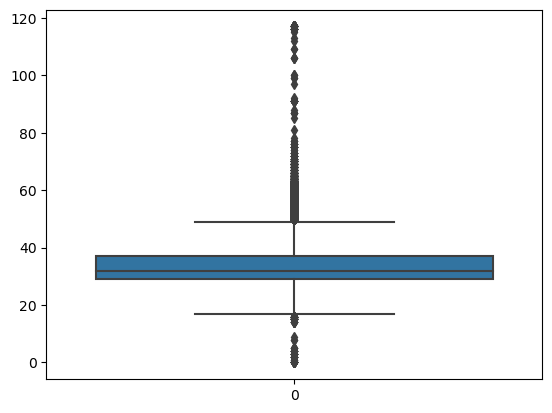

In [100]:
sns.boxplot(df['age'])
plt.show()

In [101]:

# Treating outliers in 'age'
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)

IQR = Q3 -Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['age'] = np.where((df['age'] < lower_bound) | (df['age'] > upper_bound),
                     df['age'].median(),
                     df['age'])

In [102]:
print('Q1 :', Q1)
print('Q3 :', Q3)
print('IQR :', IQR)
print('lower_bound :',lower_bound)
print('upper_bound :',upper_bound)

Q1 : 29.0
Q3 : 37.0
IQR : 8.0
lower_bound : 17.0
upper_bound : 49.0


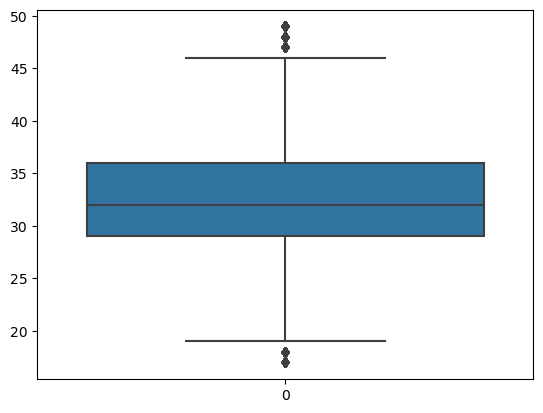

In [103]:
sns.boxplot(df['age'])
plt.show()

## 11.Check the distribution of the different categories in the column 'rented for'using appropriate plot..

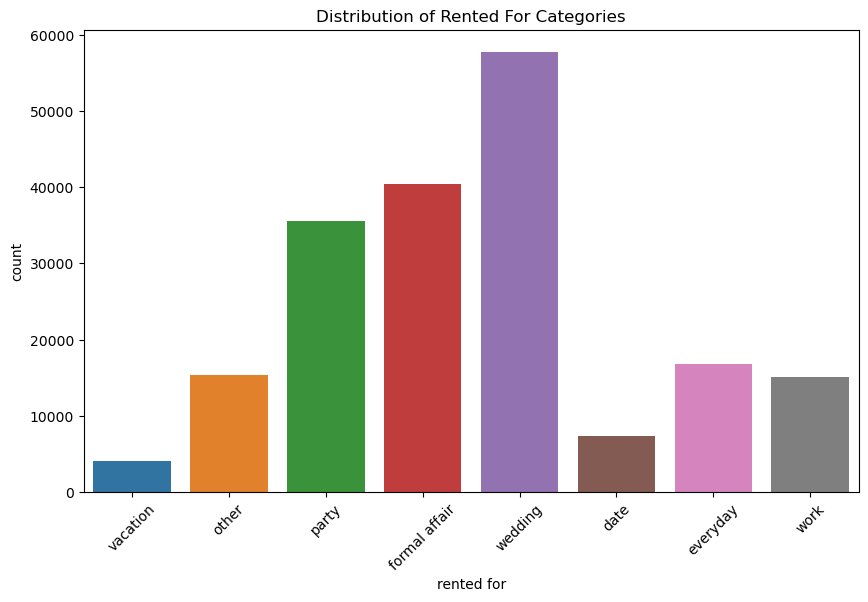

In [104]:
plt.figure(figsize=(10,6))
sns.countplot(x='rented for', data=df)
plt.xticks(rotation=45)
plt.title('Distribution of Rented For Categories')
plt.show()

## 12. Encode the categorical variables in the dataset.

In [105]:
categorical_cols = ['body type', 'rented for', 'category', 'fit']

In [111]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first = True)

In [112]:
print("Columns after encoding:")
print(df_encoded.columns)

Columns after encoding:
Index(['Unnamed: 0', 'bust size', 'weight', 'rating', 'height', 'size', 'age',
       'body type_athletic', 'body type_full bust', 'body type_hourglass',
       'body type_pear', 'body type_petite', 'body type_straight & narrow',
       'rented for_everyday', 'rented for_formal affair', 'rented for_other',
       'rented for_party', 'rented for_vacation', 'rented for_wedding',
       'rented for_work', 'category_blazer', 'category_blouse',
       'category_blouson', 'category_bomber', 'category_buttondown',
       'category_caftan', 'category_cami', 'category_cape',
       'category_cardigan', 'category_coat', 'category_combo',
       'category_crewneck', 'category_culotte', 'category_culottes',
       'category_down', 'category_dress', 'category_duster', 'category_for',
       'category_frock', 'category_gown', 'category_henley', 'category_hoodie',
       'category_jacket', 'category_jeans', 'category_jogger',
       'category_jumpsuit', 'category_kaftan', 'cat

In [113]:
# Display the first few rows of the encoded dataframe
print("\nFirst few rows of the encoded dataframe:")
df_encoded.head()


First few rows of the encoded dataframe:


,Unnamed: 0,bust size,weight,rating,height,size,age,body type_athletic,body type_full bust,body type_hourglass,...,category_tight,category_top,category_trench,category_trouser,category_trousers,category_tunic,category_turtleneck,category_vest,fit_large,fit_small
0,0,34.0,137.0,10.0,68.0,14,28.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1,34.0,132.0,10.0,66.0,12,36.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,34.0,135.0,10.0,64.0,4,32.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,3,34.0,135.0,8.0,65.0,8,34.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,34.0,145.0,10.0,69.0,12,27.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


## 13. Standardize the data, so that the values are within a particular range

In [114]:
sc = StandardScaler()
df_scaled = pd.DataFrame(sc.fit_transform(df_encoded), columns = df_encoded.columns)

In [115]:
df_scaled.head()

,Unnamed: 0,bust size,weight,rating,height,size,age,body type_athletic,body type_full bust,body type_hourglass,...,category_tight,category_top,category_trench,category_trouser,category_trousers,category_tunic,category_turtleneck,category_vest,fit_large,fit_small
0,-1.732042,-0.101135,-0.000957,0.634498,1.011893,0.206575,-0.782912,-0.541580,-0.290728,1.323321,...,-0.008827,-0.16212,-0.010192,-0.016904,-0.009669,-0.029019,-0.01329,-0.038025,-0.383677,-0.39317
1,-1.732024,-0.101135,-0.249202,0.634498,0.259688,-0.028862,0.571310,-0.541580,-0.290728,-0.755674,...,-0.008827,-0.16212,-0.010192,-0.016904,-0.009669,-0.029019,-0.01329,-0.038025,-0.383677,-0.39317
2,-1.732006,-0.101135,-0.100255,0.634498,-0.492517,-0.970608,-0.105801,-0.541580,-0.290728,1.323321,...,-0.008827,-0.16212,-0.010192,-0.016904,-0.009669,-0.029019,-0.01329,-0.038025,-0.383677,-0.39317
3,-1.731988,-0.101135,-0.100255,-0.764242,-0.116415,-0.499735,0.232754,-0.541580,-0.290728,-0.755674,...,-0.008827,-0.16212,-0.010192,-0.016904,-0.009669,-0.029019,-0.01329,-0.038025,-0.383677,-0.39317
4,-1.731970,-0.101135,0.396235,0.634498,1.387995,-0.028862,-0.952190,1.846448,-0.290728,-0.755674,...,-0.008827,-0.16212,-0.010192,-0.016904,-0.009669,-0.029019,-0.01329,-0.038025,-0.383677,-0.39317


## 14. Apply PCA on the above dataset and determine the number of PCA components to be used so that 90-95% of the variance in data is explained by the same.

In [125]:
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

n_components_90 = np.argmax(cumulative_variance_ratio >= 0.9) + 1
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print(f"Number of components explaining 90% variance: {n_components_90}")
print(f"Number of components explaining 95% variance: {n_components_95}")

Number of components explaining 90% variance: 74
Number of components explaining 95% variance: 79


## 15. Apply K-means clustering and segment the data.

## 15.a. Find the optimal K Value using elbow plot for K Means clustering.

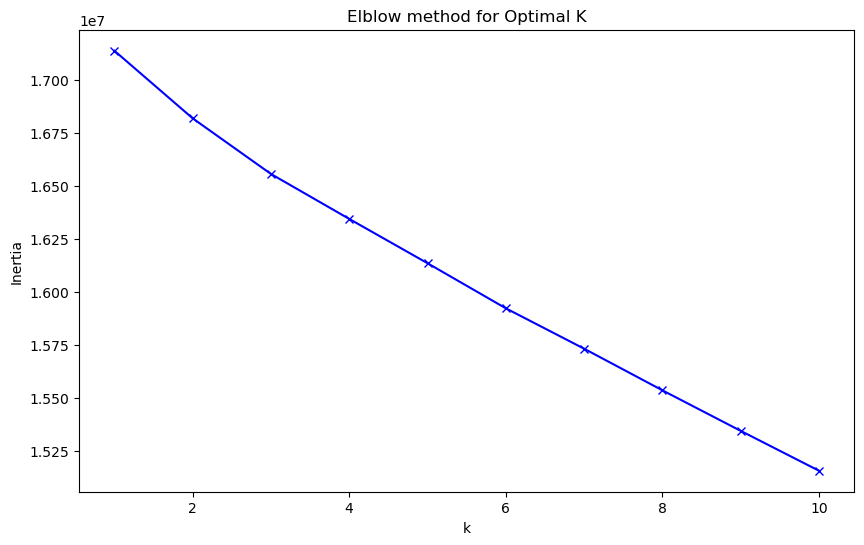

In [126]:
inertias = []
K = range(1,11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elblow method for Optimal K')
plt.show()

## 15.b. Build a Kmeans clustering model using the obtained optimal K value from the elbow plot.

In [132]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_result)

In [133]:
print('kmeans_labels', kmeans_labels)

kmeans_labels [3 2 3 ... 3 3 2]


## 15.c. Compute silhouette score for evaluating the quality of the K Means clustering technique

In [134]:
kmeans_silhouette = silhouette_score(pca_result, kmeans_labels)
print(f"K-Means silhouette Score: {kmeans_silhouette}")

K-Means silhouette Score: -0.020277162735907565


## 16. Apply Agglomerative clustering and segment the data.

## 16.a. Find the optimal K Value using dendrogram for Agglomerative clustering

In [136]:
# Take a sample to reduce computational time
sample_size = 1000
sample_indices = np.random.choice(df_scaled.index, size=sample_size, replace=False)
sample_data= pca_result[sample_indices]
print(sample_data)

[[-3.58764093e-01  6.82681240e-01 -4.70021728e-01 ... -8.27820442e-02
  -5.68757416e-03 -5.41322064e-04]
 [-1.86477289e-01 -3.97564682e-01 -1.50852588e+00 ... -5.33043733e-02
   1.23363867e-02  4.50922152e-05]
 [-2.86260355e+00  1.81728845e+00 -4.92675387e-01 ...  2.29603760e-02
  -4.49204066e-04  1.36052511e-04]
 ...
 [-3.39573436e-01 -8.63522374e-01  4.04100811e+00 ...  2.27795489e-04
   1.03395503e+00 -6.98553215e-04]
 [ 1.86138143e+00  3.02781042e+00  6.06689708e-01 ... -4.12579027e-03
  -3.77674875e-02 -2.63216330e-04]
 [-1.10337483e+00  2.61672825e+00  7.75448255e-01 ... -3.65026285e-02
   4.13787094e-02 -1.86754509e-04]]


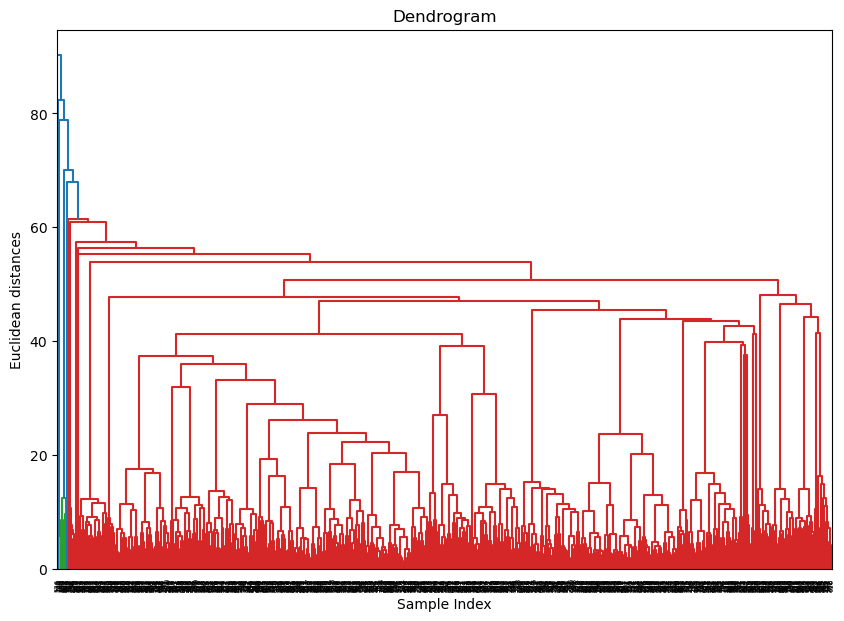

In [138]:
# a. Create dendrogram

plt.figure(figsize = (10, 7))
dendrogram = sch.dendrogram(sch.linkage(sample_data, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean distances')
plt.show()


## 16.b.  Build a Agglomerative clustering model using the obtained optimal Kvalue observed from dendrogram.

In [140]:
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(sample_data)

## 16.c. Compute silhouette score for evaluating the quality of the Agglomerative clustering technique

In [142]:
agg_silhouette = silhouette_score(sample_data, agg_labels)
print(f"Agglomerative Clustering silhouette Score: {agg_silhouette}")

Agglomerative Clustering silhouette Score: 0.7777866540279809


## 17. Perform cluster analysis by doing bivariate analysis between cluster labels and different features and write your conclusion on the results

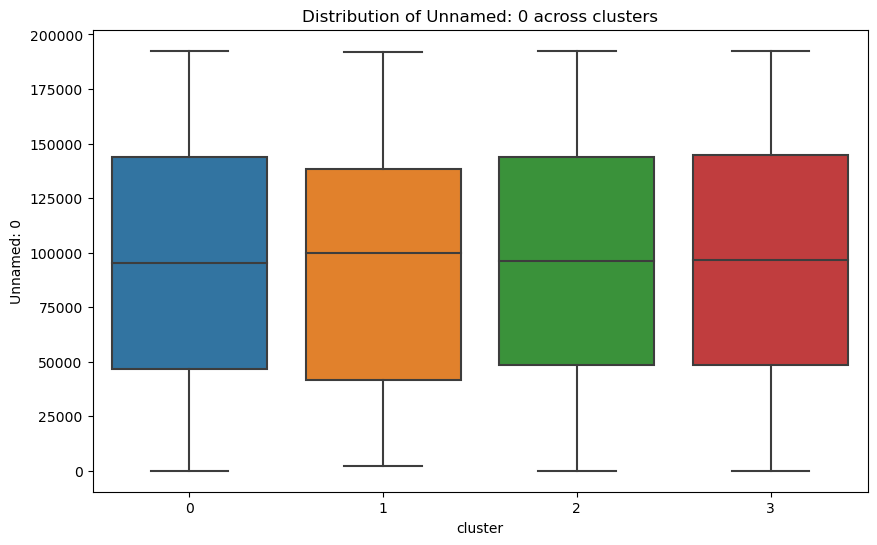

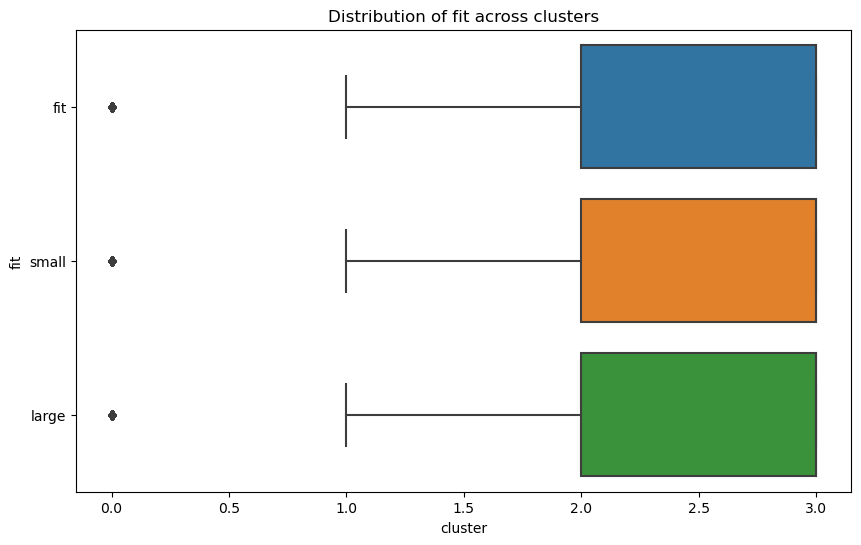

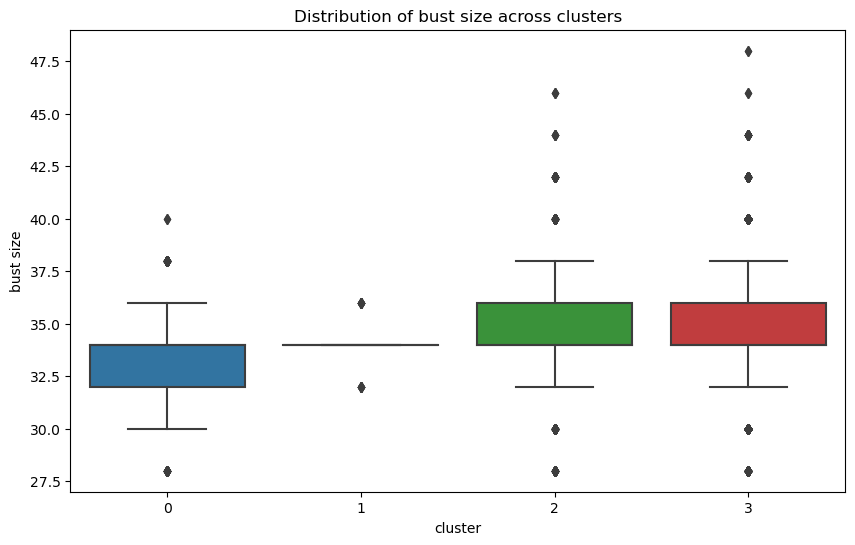

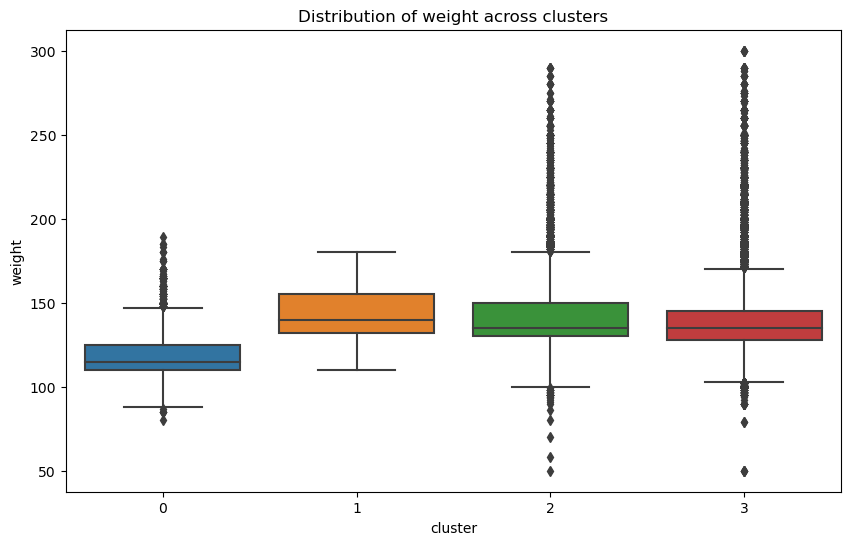

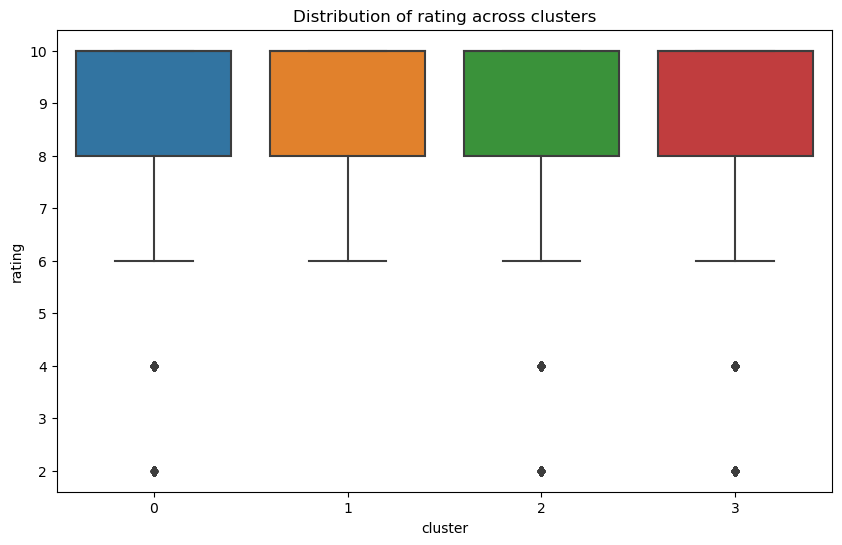

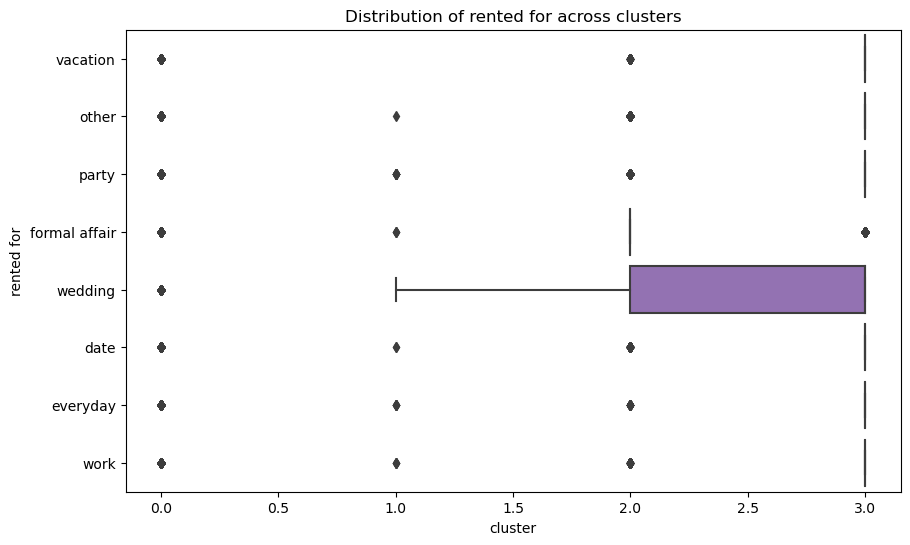

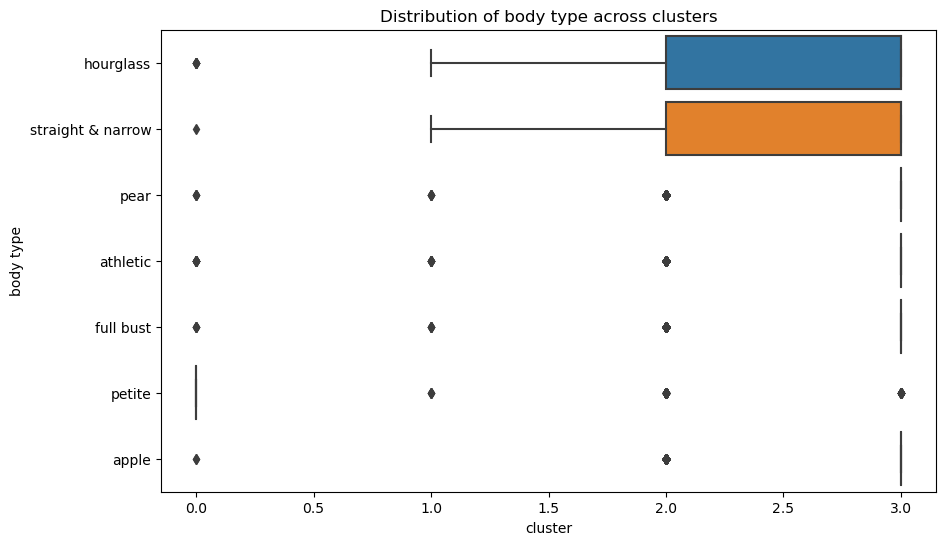

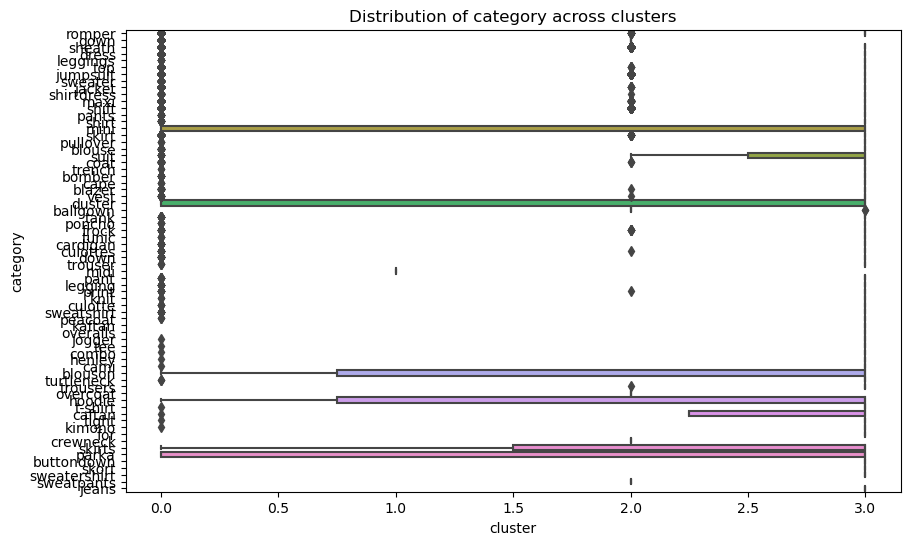

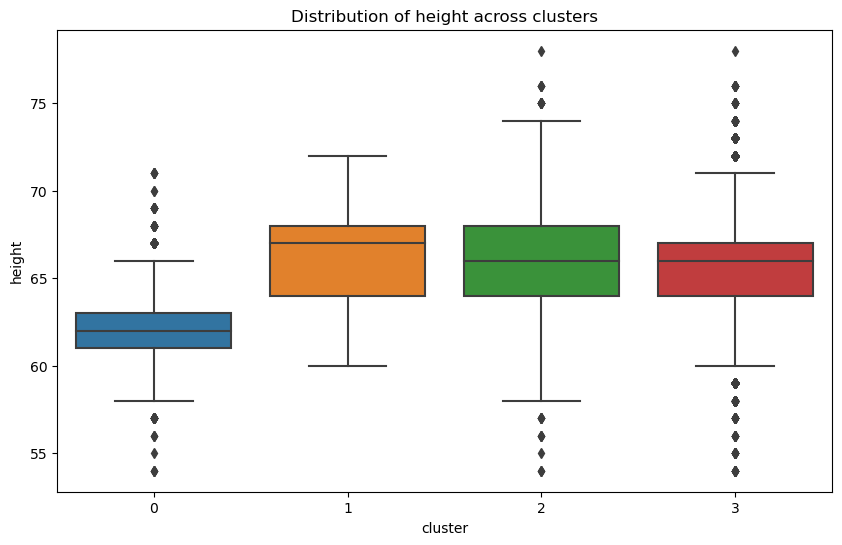

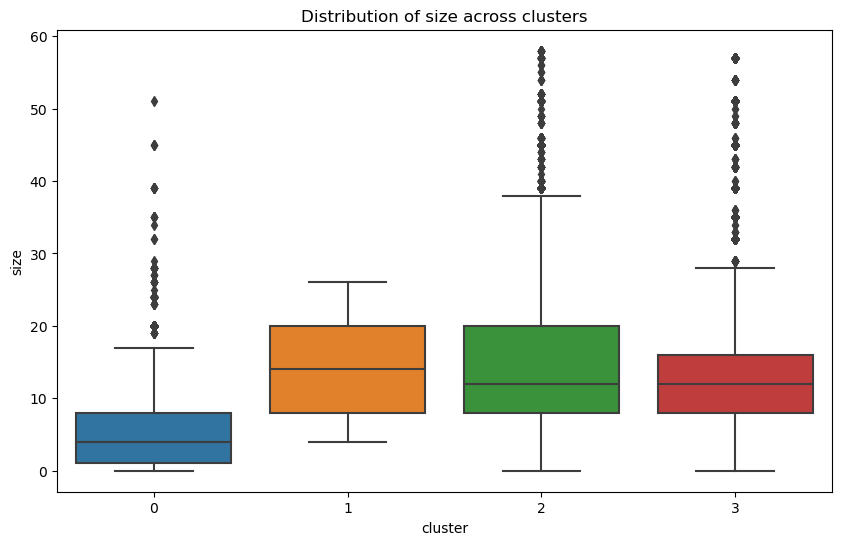

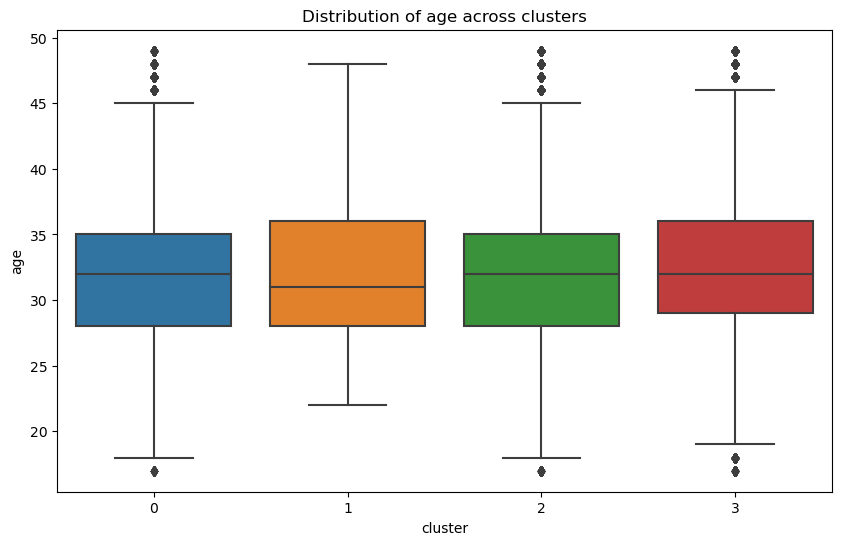

In [143]:
#Cluster analysis
df['cluster'] = kmeans_labels
for feature in df.columns:
    if feature != 'cluster':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='cluster', y=feature, data=df)
        plt.title(f'Distribution of {feature} across clusters')
        plt.show()